##Paquetes

In [ ]:
#Instalar adjustText para evitar solapamiento de textos
%%capture
!pip install adjustText

In [ ]:
#Importar los módulos de cada paquete necesarios para todas las operaciones
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from adjustText import adjust_text

##Carga del CSV

In [ ]:
df = pd.read_csv('file.csv', sep = ',') #Subir el archivo al entorno y cambiar el nombre y el separador según sea necesario
df.head() #Revisar las primeras filas para comprobar que se cargó correctamente

##Matriz de correlación

In [ ]:
props = ['MW', 'HBA', 'HBD', 'RB', 'AlogP', 'TPSA', 'AG', 'BG']
prop_df = df[props] #Crear un dataframe únicamente con las propiedades para la matriz de correlación

In [ ]:
corr_df = prop_df.corr() #Crear la matriz de correlación

In [ ]:
mask = np.triu(np.ones_like(corr_df, dtype=bool)) #Crea una máscara para mostrar solo la mitad de la matriz (los valores están reflejados respecto a la diagonal)

plt.figure(figsize=(8.6, 8)) #Definir el tamaño de la figura a conveniencia

sns.heatmap(corr_df, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .8}) #Crea el heatmap de la matriz de correlación con la máscara aplicada y el esquema de color coolwarm (azul/rojo)

plt.title('Título') #Título del gráfico

plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')

plt.show() #Muestra el heatmap

##Variabilidad explicada

In [ ]:
std = StandardScaler() #Función para estandarizar los datos

scaled_df = std.fit_transform(prop_df)
pca = PCA().fit(scaled_df) #Realiza el PCA

var = pca.explained_variance_ratio_ #Calcula la fracción de variabilidad explicada
var_sum = np.cumsum(var) #Suma la fracción de variabilidad explicada

In [ ]:
#Elementos estéticos del gráfico de variabilidad explicada
plt.axhline(y=0.7, color='gray', linestyle='--')
plt.plot(var_sum, label="Etiqueta")
plt.xlabel('Componentes principales')
plt.ylabel('Variabilidad explicada')

xticks = plt.xticks()[0] #Guarda las marcas de graduación
new_xticks = xticks + 1 #Crea nuevas marcas de graduación para iniciar por el uno
new_xticks = new_xticks[new_xticks != 0] #Remueve el primer valor de las nuevas marcas
plt.xticks(xticks[1:len(new_xticks) + 1], new_xticks.astype(int)[:len(new_xticks)]) #Reemplaza las marcas de graduación por las que inician en 1

plt.xlim(-0.5, 7.5) #Ajusta los límites del eje X

plt.savefig('explained_var.png', dpi=300, bbox_inches='tight') #Guarda el gráfico como una imagen

plt.show()

##NAPRORE-CR

In [ ]:
#Realiza la PCA para dos componentes
pca_result = PCA(n_components = 2).fit_transform(scaled_df)

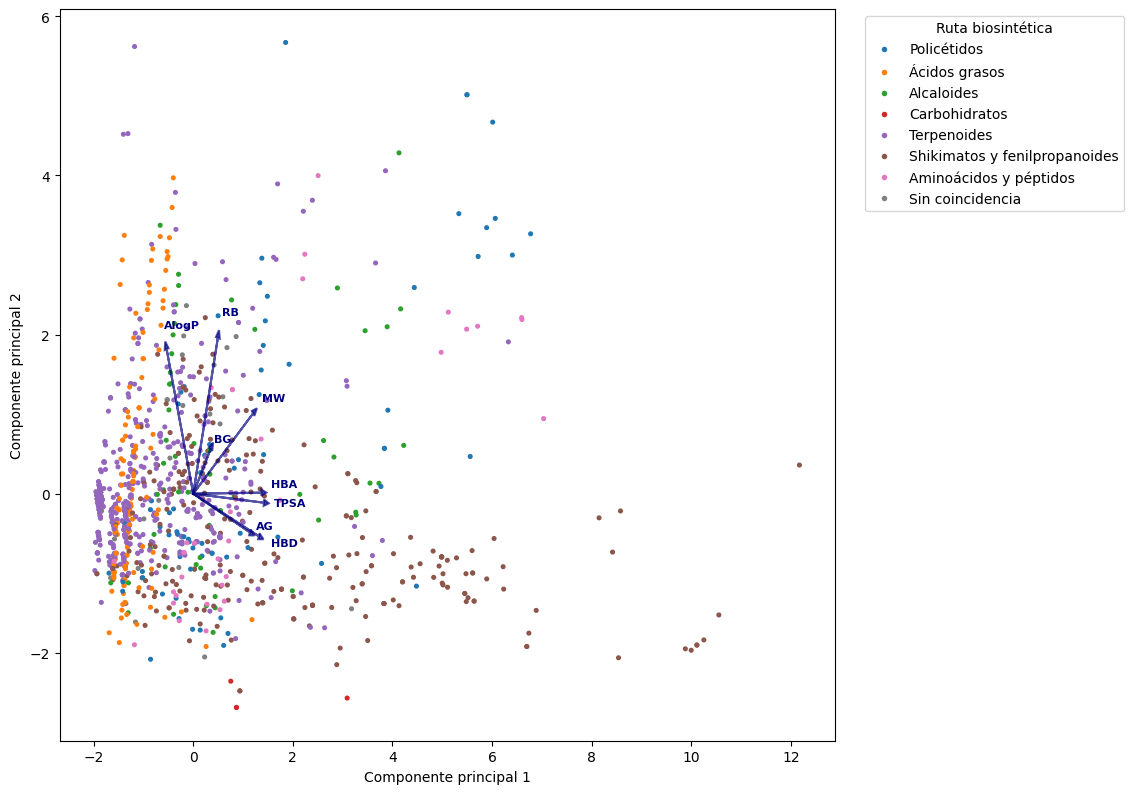

In [ ]:
#Lista de rutas metabólicas para asignar colores y nombres
pathways_list = [
    'Polyketides',
    'Fatty acids',
    'Alkaloids',
    'Carbohydrates',
    'Terpenoids',
    'Shikimates and Phenylpropanoids',
    'Amino acids and Peptides',
    'No match'
]

#Traducciones de las rutas metabólicas
pathways_names = {
    'Polyketides': 'Policétidos',
    'Fatty acids': 'Ácidos grasos',
    'Alkaloids': 'Alcaloides',
    'Carbohydrates': 'Carbohidratos',
    'Terpenoids': 'Terpenoides',
    'Shikimates and Phenylpropanoids': 'Shikimatos y fenilpropanoides',
    'Amino acids and Peptides': 'Aminoácidos y péptidos',
    'No match': 'Sin coincidencia'
}

#Paleta de colores por ruta
palette = sns.color_palette("tab10", len(pathways_list) - 1) #Define la paleta tab10. Se resta un color para definir "Sin coincidencia" como gris
fixed_color_map = {pathways_list[i]: palette[i] for i in range(len(palette))} #Crea un mapa de colores fijo para cada ruta
fixed_color_map['No match'] = 'gray' #Asigna el color gris a "Sin coincidencia"

#Añade los resultados de la PCA al df
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

pathways = df['NPC_PATHWAY_1'].tolist() #Crea una lista de rutas metabólicas según el df cargado
point_colors = [fixed_color_map[pathway] if pd.notna(pathway) else fixed_color_map['No match'] for pathway in pathways] #Revisa qué color corresponde a cada punto

#Crea el gráfico del PCA
plt.figure(figsize=(10, 9.5)) #Definir el tamaño de la figura a conveniencia
scatter = plt.scatter(df['PCA1'], df['PCA2'], s=7, c=point_colors) #Grafica los resultados del PCA como un scatter plot
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")

loadings = pca.components_.T  #Obtiene los coeficientes de los componentes para cada propiedad

#Grafica los vectores de cada propiedad
texts = []
for i, prop in enumerate(props): #Para el número de propiedades
    plt.arrow(0, 0, loadings[i, 0] * 3, loadings[i, 1] * 3,
              color='navy', alpha=0.67, linewidth=1.5,
              head_width=0.08, head_length=0.1) #Extrae los coeficientes de las dos primeras propiedades y define parámetros de los vectores como origen, componentes y aspectos estéticos (color, grosor)
    texts.append(plt.text(loadings[i, 0] * 3.4, loadings[i, 1] * 3.4, prop,
                          color='navy', fontsize=8, fontweight='semibold')) #Añade un texto con las siglas de la propiedad

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='navy', lw=0.5)) #Ajusta el texto para evitar solapamiento

#Crea una leyenda con los colores asignados a cada ruta
handles = [plt.Line2D([0], [0], marker='o', color='w', label=pathways_names[pathway],
                       markerfacecolor=fixed_color_map[pathway], markersize=5) for pathway in pathways_list]
plt.legend(title='Ruta biosintética', handles=handles, bbox_to_anchor=(1.03, 1), loc='upper left')

plt.savefig('PCA_NAPRORE.png', dpi=300, bbox_inches='tight') #Guarda el gráfico como una imagen

plt.show()

##Conjuntos combinados

In [ ]:
cc_df = pd.read_csv('COMBINED_SETS_F.csv', sep = ';') #Subir el archivo al entorno y cambiar el nombre y el separador según sea necesario
cc_df.head() #Revisar las primeras filas para comprobar que se cargó correctamente

,Unnamed: 0,NAME,SMILES,SET,MW,HBA,HBD,RB,AlogP,TPSA,AG,BG
0,1,Leuprolide,CCNC(=O)C1CCCN1C(=O)[C@H](CCCN=C(N)N)NC(=O)[C@...,DrugBank approved,1209.421,14,15,32,-1.43810,431.54,10,4
1,2,Goserelin,CC(C)CC(NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H](Cc...,DrugBank approved,1269.433,16,17,31,-3.10570,495.89,13,4
2,4,Desmopressin,N=C(N)NCCCC(NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1CSSC...,DrugBank approved,1069.238,15,14,19,-4.13203,435.41,8,3
3,5,Cetrorelix,CC(=O)NC(Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1ccc(Cl...,DrugBank approved,1431.064,16,16,38,-0.71580,498.17,11,4
4,6,Vasopressin,N=C(N)NCCCC(NC(=O)C1CCCN1C(=O)C1CSSCC(N)C(=O)N...,DrugBank approved,1084.253,16,15,19,-5.19483,461.43,8,4


In [ ]:
cc_props_df = cc_df[props] #Crear un dataframe únicamente con las propiedades para la matriz de correlación
cc_scaled_df = std.fit_transform(cc_props_df)

pca_cc = PCA().fit(cc_scaled_df) #Realiza el PCA

#Realiza la PCA para dos componentes
pca_cc_result = PCA(n_components = 2).fit_transform(cc_scaled_df)

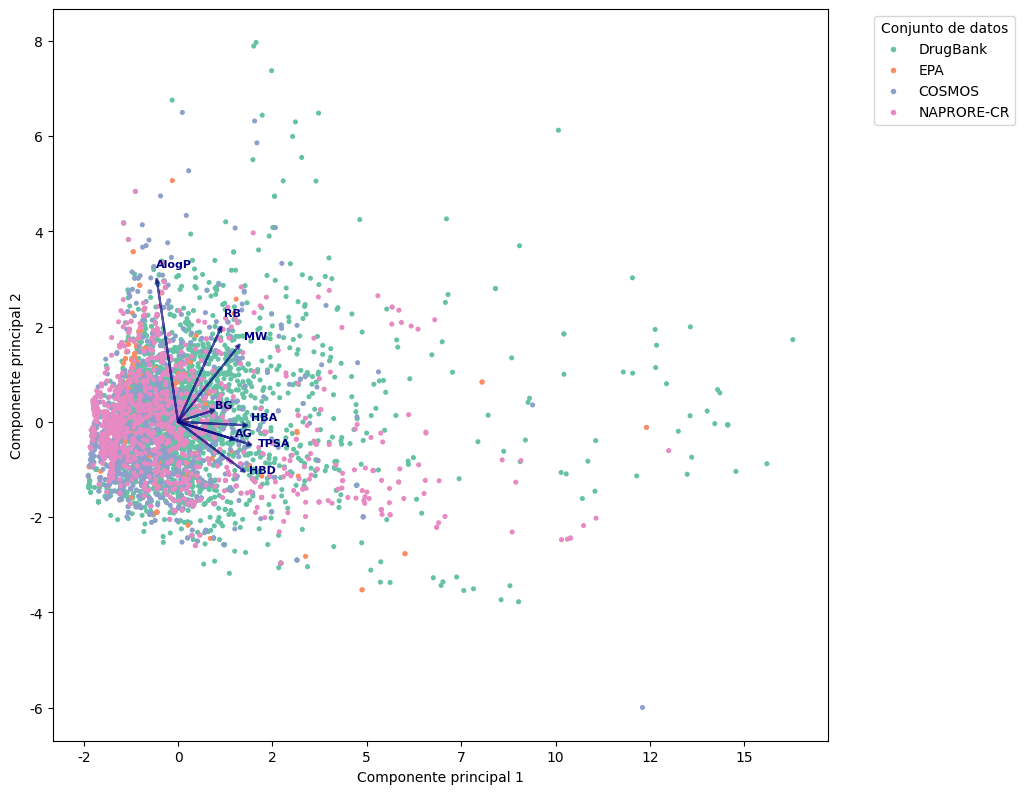

In [ ]:
#Define el orden y las abreviaturas de cada conjunto para la leyenda y la asignación de colores
abbreviation_map = {
    'DrugBank approved': 'DrugBank',
    'EPA natural pesticides': 'EPA',
    'COSMOS cosmetic ingredients': 'COSMOS',
    'NAPRORE-CR': 'NAPRORE-CR',
}

#Añade los resultados de la PCA al cc_df
cc_df['PCA1'] = pca_cc_result[:, 0]
cc_df['PCA2'] = pca_cc_result[:, 1]

unique_sets = cc_df['SET'].unique() #Crea una lista de los nombres de todos los conjuntos
palette = sns.color_palette("Set2", len(unique_sets)) #Define la paleta de colores Set2
color_map = {set_name: color for set_name, color in zip(unique_sets, palette)} #Asigna un color a cada conjunto

sets = cc_df['SET'].tolist() #Toma el conjunto de cada fila del cc_df
point_colors = [color_map[set] for set in sets] #Asigna su respectivo color según su conjunto

#Crea el gráfico del PCA
plt.figure(figsize=(10, 9.5))  #Definir el tamaño de la figura a conveniencia
scatter = plt.scatter(cc_df['PCA1'], cc_df['PCA2'], s=7, c=point_colors)  #Grafica los resultados del PCA como un scatter plot
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")

#Elimina los decimales de las marcas de graduación
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

loadings = pca_cc.components_.T  #Obtiene los coeficientes de los componentes para cada propiedad

#Grafica los vectores de cada propiedad
texts = []
for i, prop in enumerate(props):
    plt.arrow(0, 0, loadings[i, 0] * 4, loadings[i, 1] * 4,
              color='navy', alpha=0.67, linewidth=1.5,
              head_width=0.08, head_length=0.1)
    texts.append(plt.text(loadings[i, 0] * 4.4, loadings[i, 1] * 4.4, prop,
                          color='navy', fontsize=8, fontweight='semibold'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='navy', lw=0.5)) #Ajusta el texto para evitar solapamiento

#Crea una leyenda con los colores y el orden de conjuntos definido
handles = [plt.Line2D([0], [0], marker='o', color='w', label=abbreviation_map[set_name],
                       markerfacecolor=color_map[set_name], markersize=5) for set_name in unique_sets]
plt.legend(title='Conjunto de datos', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('PCA_cc.png', dpi=300, bbox_inches='tight') #Guarda el gráfico como una imagen

plt.show()

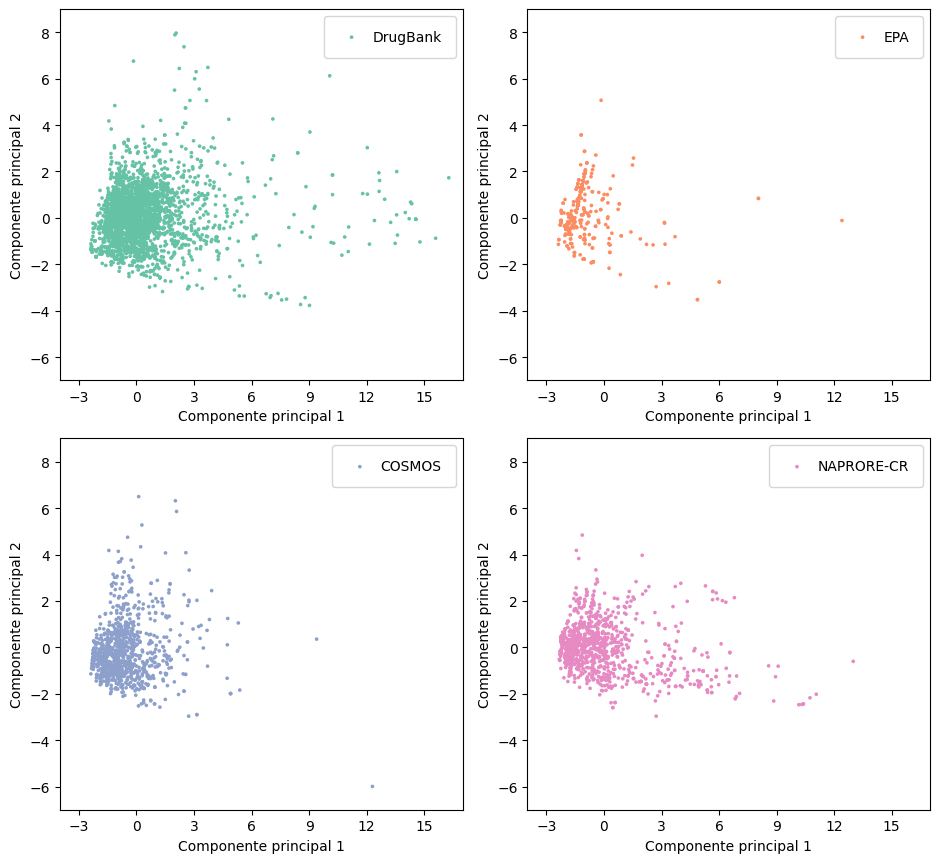

In [ ]:
#Genera los subgráficos por conjunto

#Crea una cuadrícula de 2x2
fig, axes = plt.subplots(2, 2, figsize=(9.5, 9.5))

#Define límites para ambos ejes comunes a todos los subgráficos
x_limits = [-4, 17]
y_limits = [-7, 9]

#Ciclo para graficar individualmente cada conjunto
for i, (set_name, ax) in enumerate(zip(unique_sets, axes.ravel())):
    #Filtrar por cada conjunto
    subset = cc_df[cc_df['SET'] == set_name]

    #Graficar el conjunto actual
    sns.scatterplot(x='PCA1', y='PCA2', data=subset, color=color_map[set_name], ax=ax, s=7, edgecolor='none')

    #Aplica los límites de los ejes
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    #Modifica los marcadores para que sean todos números enteros
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    #Añade una leyenda con el color y abreviatura del conjunto
    ax.legend([abbreviation_map[set_name]], loc='upper right', frameon=True, markerscale=1, fontsize=10,
              handletextpad=0.5, borderpad=1, fancybox=True, handlelength=2, title_fontsize='13', labelspacing=0.6)

    #Añade etiquetas de los ejes al subgráfico
    ax.set_xlabel('Componente principal 1')
    ax.set_ylabel('Componente principal 2')

#Ajusta la distribución de los subgráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('PCA_cc_cua.png', dpi=300, bbox_inches='tight') #Guarda el gráfico como una imagen

# Show plot
plt.show()